In [1]:
import juliet
import etta
import pickle

from sympy import *
from numpy import *
from tabulate import tabulate
from colorama import*
from matplotlib.offsetbox import*

import pandas as pd

font1 = {'family':'serif','color':'black'}

import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np
import os
import sys

import astropy
from astropy.io import fits
from astropy.stats import sigma_clip
from transitleastsquares import (transitleastsquares, cleaned_array, catalog_info, transit_mask)

C:\Users\computer\anaconda3\lib\site-packages\autograd\numpy\numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


problem: Could not find module 'libmultinest.dll' (or one of its dependencies). Try using the full path with constructor syntax.


In [2]:
def plot_in_out_TPF(TOI_ID, Sector, tpf,  T0, duration, save_i):

    tpf_list = [tpf.flux.value]
    t_list = [tpf.time.value]
    T0_list = [T0]
    
    plt.figure(figsize=(9,2.5*len(T0_list)))

    plt.tight_layout()

    count = 0 # keep track of how many images have been plotted to that they appear on a subgrid of plots which has three columns

    # loop through all of the list of PCA corrected flux vs time arrays for each marked transit-event
    for idx, tpf_filt in enumerate(tpf_list): # idx is for each maked transit-event

        T0 = T0_list[idx] # the time of the transit-like event
        t = t_list[idx] # the time array

        intr = abs(T0-t) < (duration/2 + 0.002)  # create a mask of the in transit times
        oot = (abs(T0-t) < 0.5) * (abs(T0-t) > (duration/2 + 0.002))  # create a mask of the out of transit times
        img_intr = tpf_filt[intr,:,:].sum(axis=0)/float(intr.sum()) # apply the masks and normalize the flux
        img_oot = tpf_filt[oot,:,:].sum(axis=0)/float(oot.sum())
        img_diff = img_oot-img_intr # calculate the diffefence image (out of transit minus in-transit)

        
        # ---- PLOT -------
        
        # in transit
        count += 1 # add to the count before each plot
        plt.subplot(len(T0_list), 3, count)
        plt.axis('off')
        plt.imshow(img_intr, cmap=plt.cm.viridis, origin = 'lower')
        plt.colorbar()
        plt.title("t = {} days \n In Transit Flux (e-/candence)".format(T0), fontsize = 9 )

        # out of transit
        count += 1
        plt.subplot(len(T0_list), 3, count)
        plt.axis('off')
        plt.imshow(img_oot, cmap=plt.cm.viridis, origin = 'lower')
        plt.colorbar()
        plt.title("Out of Transit Flux (e-/candence)", fontsize = 9 )

        # out of transit minus in-transit
        count += 1
        plt.subplot(len(T0_list), 3, count)
        plt.axis('off')
        plt.imshow(img_diff, cmap=plt.cm.viridis, origin = 'lower')
        plt.colorbar()
        plt.title("Difference Flux (e-/candence)", fontsize = 9 )
    
    plt.subplots_adjust(wspace = 0)
    plt.tight_layout()
    plt.savefig(os.path.join('', 'TOI_'+TOI_ID+'_S_'+Sector+'_IOT_'+str(save_i)+'.jpeg'), format='jpeg', dpi=600, bbox_inches = 'tight')     
    
    
    
def plot_pixel_level_LC(TOI_ID, Sector, tpf, transit_time, save_i, duration, ql = False):
    
    transit_list = [transit_time]
    t_list = [tpf.time.value]
    tpf_list = [tpf.flux.value]
    bkg_list = [np.nanmean(tpf.flux.value,axis = 0)]
    arrshape_list = [tpf.flux.shape]

    # loop through the transits and make plot for each (only the first is currently displayed in the pdf report)
    for idx, X1_original in enumerate(tpf_list):

        bkg = np.flip(bkg_list[idx], axis = 0)
        arrshape = arrshape_list[idx]
        peak = transit_list[idx]
        tpf = tpf_list[idx]
        
        s = X1_original.shape
        X1 = X1_original.reshape(s[0],s[1]*s[2])
        
        T0 = transit_list[idx] # the time of the transit-like event
        t = t_list[idx] # the time array

        intr = abs(T0-t) < (duration/2 + 0.002)  # create a mask of the in transit times
        oot = (abs(T0-t) < 0.5) * (abs(T0-t) < (duration/2 + 0.002))  # create a mask of the out of transit times
        

        fig, ax = plt.subplots(arrshape[1], arrshape[2], sharex = True, sharey = False, gridspec_kw={'hspace': 0 ,'wspace': 0}, figsize=(5.5,5.5))

        plt.tight_layout()

        # see if the backrgound of this plot can be the average pixel flux (if there are too many nans this will fail and the background will just be black which is also okay)
        try:
            color = plt.cm.viridis(np.linspace(0, 1,int(np.nanmax(bkg))-int(np.nanmin(bkg))+1))
            simplebkg = False
        except:
            simplebkg = True

        for i in range(0,arrshape[1]):
            ii = arrshape[1]-1-i # we want to plot this such that the pixels increase from left to right and bottom to top

            for j in range(0,arrshape[2]):

                apmask = np.zeros(arrshape[1:], dtype=np.int)
                apmask[i,j] = 1
                apmask = apmask.astype(bool)
                
                flux = X1[:,apmask.flatten()].sum(axis=1)

                m = np.nanmedian(flux[oot])

                normalizedflux = flux/m

                # bin the data
                f1 = normalizedflux
                time = t


                binfac = 7

                N       = len(time)
                n       = int(np.floor(N/binfac)*binfac)
                X       = np.zeros((2,n))
                X[0,:]  = time[:n]
                X[1,:]  = f1[:n]
                Xb      = rebin(X, (2,int(n/binfac)))

                # binned data
                time_binned    =    np.array(Xb[0])
                flux_binned    =   np.array(Xb[1])

                
                # create a mask that only looks at the times cut around the transit-event
                timemask = (time_binned < peak+1.5) & (time_binned > peak-1.5)

                time_binned = time_binned[timemask]
                flux_binned = flux_binned[timemask]

                # ----------
                # fit a spline to the cut-out of each pixel LC in order to flatten it
                p = np.poly1d(np.polyfit(time_binned, flux_binned, 3))
                flux_binned = flux_binned/p(time_binned)
                # ----------

                intr = abs(peak-time_binned) < 0.1

                if simplebkg == True:
                    ax[ii, j].set_facecolor(color = 'k')
                    linecolor = 'w'
                    transitcolor = 'gold'
                else:
                    ax[ii, j].set_facecolor(color = color[int(bkg[ii,j])-int(np.nanmin(bkg))])

                    if int(bkg[ii,j])-abs(int(np.nanmin(bkg))) > ((np.nanmax(bkg))-abs(int(np.nanmin(bkg))))/2:
                        linecolor = 'k'
                        transitcolor = 'orangered'
                    else:
                        linecolor = 'w'
                        transitcolor = 'gold'


                ax[ii, j].plot(time_binned,flux_binned, color = linecolor, marker = '.', markersize=1, lw = 0)
                ax[ii, j].plot(time_binned[intr],flux_binned[intr], color = transitcolor, marker = '.', markersize=1, lw = 0)

                # get rid of ticks and ticklabels
                ax[ii,j].set_yticklabels([])
                ax[ii,j].set_xticklabels([])
                ax[ii,j].set_xticks([])
                ax[ii,j].set_yticks([])
     
    
        # label the pixels

        fig.text(0.5,0.01, "column (pixel)", ha='center', fontsize = 13)
        fig.text(0.01, 0.5, "row (pixel)", va='center', rotation='vertical', fontsize = 13)

        # - - - - - - - - - -

        plt.subplots_adjust(top=0.95, right = 0.99, bottom = 0.04, left = 0.04)

        plt.suptitle(r"T0 = {} $\pm$ 1.5 d".format(peak ),y=0.98, fontsize = 12)
        plt.xlim(peak-1.5,peak+1.5)
        plt.show()
        
        fig.savefig(os.path.join('', 'TOI_'+TOI_ID+'_S_'+Sector+'_PLL_'+str(save_i)+'.jpeg'), format='jpeg', dpi=600, bbox_inches = 'tight')
        
def rebin(arr,new_shape):

    ''''
    function used to rebin the data
    '''
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
        new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)


def plot_centroids(TOI_ID, Sector, lc, transit_time, window, save_i):
        
    # bin the data 
    lc_bin = lc.bin(7/60/24)
    
    # generate a mask so that we only see the times around the transit event
    if (window == None) or (transit_time == None):
        transit_mask = lc_bin.time.value > 0
    else:
        transit_mask = (lc_bin.time.value > transit_time - window) & (lc_bin.time.value < transit_time + window)
        
    # make a plot with three panels so that we can see the lightcurve and the centroid positions 
    fig, ax = plt.subplots(3,1, figsize = (6,5), sharex= True)
    
    # plot the lightcurve in the top panel (in orange) 
    ax[0].plot(lc_bin.time.value[transit_mask], lc_bin.sap_flux.value[transit_mask], color = 'dodgerblue', lw = 0, marker = '.', ms = 4)
    
    # plot the centroid motions in the column direction in the middle panel
    ax[1].plot(lc_bin.time.value[transit_mask], lc_bin.mom_centr1.value[transit_mask]-np.nanmean(lc_bin.mom_centr1.value[transit_mask]), color = 'black', lw = 0, marker = '.', ms = 4, alpha = 0.8)
    ax[1].plot(lc_bin.time.value[transit_mask], lc_bin.pos_corr1.value[transit_mask]-np.nanmean(lc_bin.pos_corr1.value[transit_mask]), color = 'red', lw = 0, marker = '.', ms = 4, alpha = 0.8)
    
    # plot the centroid motions in the row direction in the middle panel
    ax[2].plot(lc_bin.time.value[transit_mask], lc_bin.mom_centr2.value[transit_mask] - np.nanmedian(lc_bin.mom_centr2.value[transit_mask]), color = 'black', lw = 0, marker = '.', ms = 4, alpha = 0.8, label = 'Brightness motion')
    ax[2].plot(lc_bin.time.value[transit_mask], lc_bin.pos_corr2.value[transit_mask]- np.nanmedian(lc_bin.pos_corr2.value[transit_mask]), color = 'red', lw = 0, marker = '.', ms = 4, alpha = 0.8, label = 'Satellite motion')
    
    if (transit_time != None):
        # draw a vertical line at the time of the transit event 
        ax[0].axvline(transit_time, color = 'grey', zorder = -1)
        ax[1].axvline(transit_time, color = 'grey', zorder = -1)
        ax[2].axvline(transit_time, color = 'grey', zorder = -1)
    
    # label the axes
    ax[0].set_ylabel("Flux")
    ax[1].set_ylabel("Column position")
    ax[2].set_ylabel("Row position")
    plt.xlabel("Time (BJD)")
    plt.xticks(rotation = 90)
    
    if (window != None) and (transit_time != None):  
        plt.xlim(transit_time - window, transit_time + window)
        
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    fig.savefig(os.path.join('', 'TOI_'+TOI_ID+'_S_'+Sector+'_CPT_'+str(save_i)+'.jpeg'), format='jpeg', dpi=600, bbox_inches = 'tight')

In [3]:
def check_make_dir(dir_name):
    if os.path.isdir(dir_name) == False:
        print("Created new Directory ("+dir_name+") to save Output")
        os.mkdir(dir_name)
    else:
        print("Directory ("+dir_name+") is already available to store output")

In [4]:
# Provide a Full Path to the Light Curve & Target Pixel File
# Make sure that both files are from same sectors

# Define the TOI ID of a Target
TOI_ID = '2443' # Only number i.e., if the target is TOI 111 then only write 111
Sector = '31'

check_make_dir('TOI '+TOI_ID)

# Provide a Path to the .fits files

os.chdir('E:/MAST TESS Data/TOI '+TOI_ID)
print(os.getcwd())

Target_Pixel_File = "tess2020294194027-s0031-0000000318753380-0198-s_tp.fits"
Light_Curve_File  = "tess2020294194027-s0031-0000000318753380-0198-s_lc.fits"

hdu = fits.open(Light_Curve_File) # Read the light curve file

tpf = lk.read(Target_Pixel_File) 
lc = lk.read(Light_Curve_File).normalize()

os.chdir('C:/Users/computer/Exoplanets_Programing/FPP Calculator/VaTEST/TOI '+TOI_ID)
print(os.getcwd())

Directory (TOI 2443) is already available to store output
E:\MAST TESS Data\TOI 2443
C:\Users\computer\Exoplanets_Programing\FPP Calculator\VaTEST\TOI 2443


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

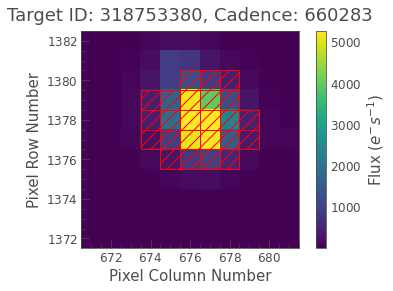

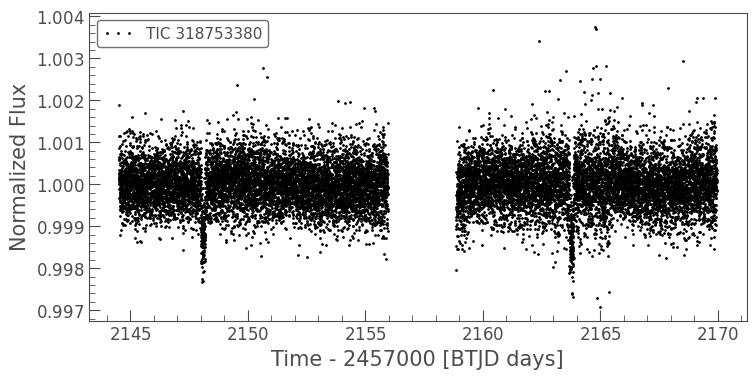

In [5]:
tpf.plot(aperture_mask='pipeline')
lc.plot(linewidth = 0, marker = '.', color = 'black')

In [6]:
count = 0
for c in range(tpf.shape[1]):
    for r in range(tpf.shape[2]):
        if tpf.pipeline_mask[c][r] == True:
            count += 1
print("Number of pixels inside Aperture Mask : ",count)

pixels = count
arsecsq = pixels * 21**2.0
radius = np.sqrt(arsecsq / np.pi)
effective_radius = radius + 6
print("MAXRAD:", effective_radius)

Number of pixels inside Aperture Mask :  24
MAXRAD: 64.04301711118435


In [7]:
# Extracting the data
time_tls = hdu[1].data['TIME']
flux_tls = hdu[1].data['PDCSAP_FLUX']  

time_tls, flux_tls = cleaned_array(time_tls, flux_tls) # remove invalid values such as nan, inf, non, negative
flux_tls = flux_tls / np.median(flux_tls) # Normalising the light curve

# Run the model to the data
model_tls = transitleastsquares(time_tls, flux_tls)
results_tls = model_tls.power(n_transits_min = 1)

Transit Least Squares TLS 1.0.31 (22 Nov 2021)


  0%|          | 0/2558 periods | 00:00<?

Creating model cache for 42 durations
Searching 16177 data points, 2558 periods from 0.601 to 25.429 days
Using all 4 CPU threads


100%|██████████| 2558/2558 periods | 01:17<00:00
  0%|          | 0/5521 [00:00<?, ?it/s]

Searching for best T0 for period 15.67984 days


100%|██████████| 5521/5521 [00:02<00:00, 2259.03it/s]


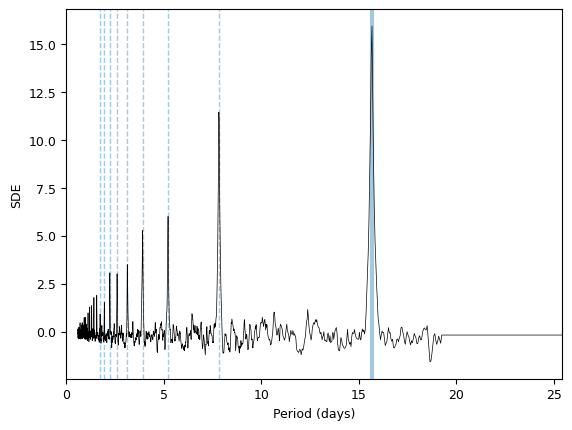

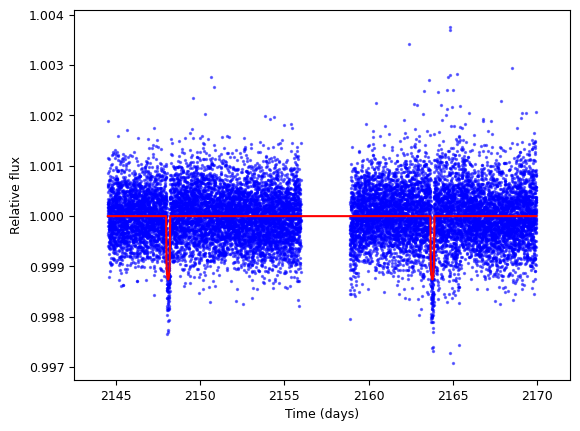

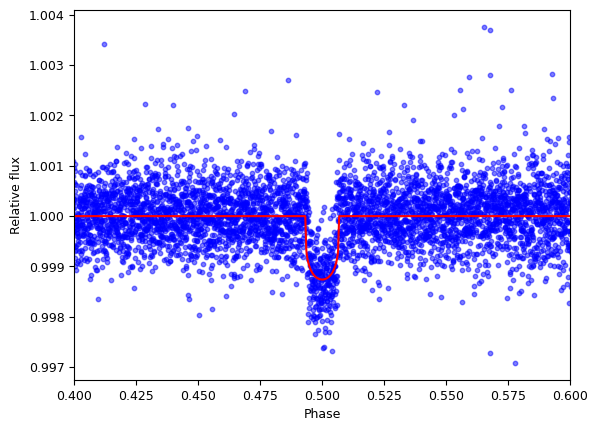

In [8]:
plt.figure()
ax = plt.gca()
ax.axvline(results_tls.period, alpha=0.4, lw=3)
plt.xlim(np.min(results_tls.periods), np.max(results_tls.periods))

for n in range(2, 10):
    ax.axvline(n*results_tls.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results_tls.period / n, alpha=0.4, lw=1, linestyle="dashed")

# Periodogram
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results_tls.periods, results_tls.power, color='black', lw=0.5)
plt.xlim(0, max(results_tls.periods));

# Transit Light Curve
plt.figure()
in_transit = transit_mask(time_tls, results_tls.period, results_tls.duration, results_tls.T0)
plt.scatter(time_tls, flux_tls, color='blue', alpha=0.5, s=2, zorder=1)
plt.plot(results_tls.model_lightcurve_time, results_tls.model_lightcurve_model, color='red', zorder=1)
plt.xlim(time_tls.min() - 2, time_tls.max() + 2)
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');

# Phase Folded Transit Light Curve
plt.figure()
plt.plot(results_tls.model_folded_phase, results_tls.model_folded_model, color='red', zorder = 1)
plt.scatter(results_tls.folded_phase, results_tls.folded_y, color='blue', s=10, alpha=0.5, zorder=0)
plt.xlim(0.4, 0.6)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

In [9]:
print('Period (P) = ', results_tls.period, '+/-', results_tls.period_uncertainty,' d') 
print('Epoch Time (T0) = ', results_tls.T0)
print('Transit duration (TD) = ', results_tls.duration, 'd')
print('Rp/Rs = ', results_tls.rp_rs)
print('')
print('Signal to Noise Ratio (SNR) = ', results_tls.snr)
print('False Alarm Probability (FAP) = ', results_tls.FAP)
print('SDE (1 - FAP) = ', 1 - results_tls.FAP)

Period (P) =  15.67983694543474 +/- 0.13592887967983547  d
Epoch Time (T0) =  2148.09373134495
Transit duration (TD) =  0.20358882908076664 d
Rp/Rs =  0.03191387281311657

Signal to Noise Ratio (SNR) =  33.345450840198495
False Alarm Probability (FAP) =  8.0032e-05
SDE (1 - FAP) =  0.999919968


In [10]:
print('All Transit times in time series (Model) = ')
print(['{0:0.5f}'.format(i) for i in results_tls.transit_times])

for i in range(np.size(results_tls.per_transit_count)):
    if results_tls.per_transit_count[i] == 0:
        results_tls.transit_times.pop(i)

print(' ')
print("If no transits available in data then respective transit time will be removed from the array")
print('Transit times in time series (Data) = ')
print(['{0:0.5f}'.format(i) for i in results_tls.transit_times])

All Transit times in time series (Model) = 
['2148.09373', '2163.77357']
 
If no transits available in data then respective transit time will be removed from the array
Transit times in time series (Data) = 
['2148.09373', '2163.77357']


In [11]:
transit_time = results_tls.transit_times # Providing all the transit times generated from TLS
with open('01) Juliet/TOI_'+TOI_ID+'_Global_Fit/_dynesty_NS_posteriors.pkl', 'rb') as f:
    data = pickle.load(f)

period = np.median(data['posterior_samples']['P_p1'])
r1 = np.median(data['posterior_samples']['r1_p1'])
r2 = np.median(data['posterior_samples']['r2_p1'])
pl = data['pl']
pu = data['pu']
ars = np.median(data['posterior_samples']['a_p1'])

Ar = (pu - pl)/(2 + pu + pl)
if r1 > Ar:
    b = (1 + pl)*(1 + (r1 - 1)/(1 - Ar))
    rprs = (1 - r2)*pl + r2*pu
if r1 <= Ar:
    b = (1 + pl) + np.sqrt(r1/Ar)*r2*(pu - pl)
    rprs = pu + (pl - pu)*np.sqrt(r1/Ar)(1 - r2)
    
inc = np.arccos(b/ars)
duration = (period/np.pi)*np.arcsin(np.sqrt(1 + rprs - b**2)/(np.sqrt(1 - (np.cos(inc))**2)*ars)) + 0.01

In [12]:
check_make_dir('02) LATTE')
os.chdir('02) LATTE')

check_make_dir('Sector '+Sector)
os.chdir('Sector '+Sector)

os.getcwd()

Directory (02) LATTE) is already available to store output
Created new Directory (Sector 31) to save Output


'C:\\Users\\computer\\Exoplanets_Programing\\FPP Calculator\\VaTEST\\TOI 2443\\02) LATTE\\Sector 31'

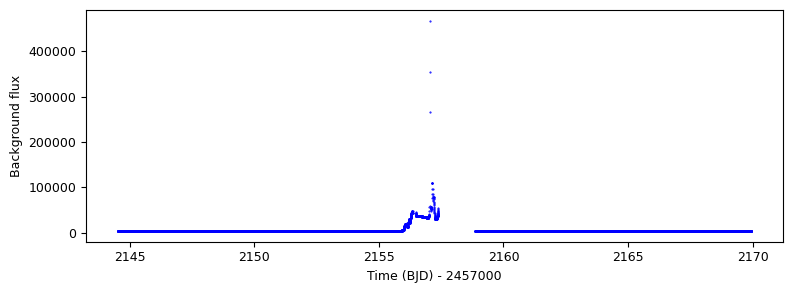

In [13]:
# set up the plotting region
fig, ax = plt.subplots(figsize = (8,3))

# plot the time vs the backrgound flux (see above cell)
plt.plot(lc.time.value, lc.sap_bkg.value, color = 'blue', lw = 0, marker = '.', ms = 1)

plt.ylabel("Background flux") # label the axes
plt.xlabel("Time (BJD) - 2457000")
plt.tight_layout()
plt.show()

fig.savefig(os.path.join('', 'TOI_'+TOI_ID+'_S_'+Sector+'_BG_.jpeg'), format='jpeg', dpi=600, bbox_inches = 'tight')

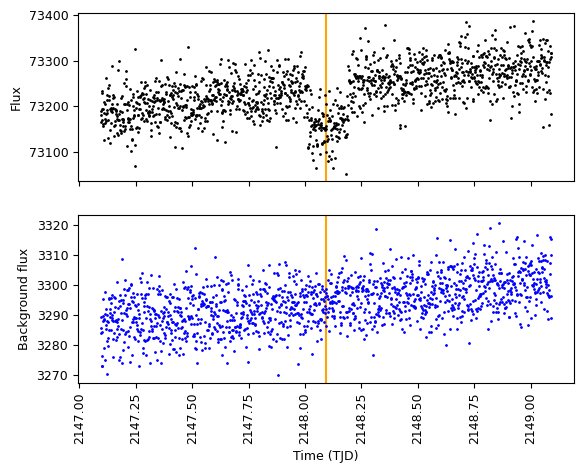

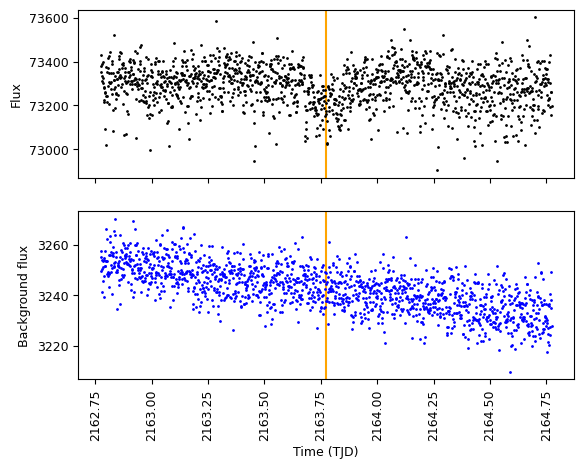

In [14]:
for i in range(np.size(transit_time)):
    # define a plotting region with two parts
    fig, ax = plt.subplots(2,1, sharex = True)

    transit_mask = (lc.time.value > transit_time[i] - 1) & (lc.time.value < transit_time[i] + 1)
    
    #plot the flux on the first axes and the background flux on the second
    #crop both data sets using the mask that we defined in the cell above
    ax[0].plot(lc.time.value[transit_mask], lc.sap_flux.value[transit_mask], color = 'k', lw = 0, marker = '.', ms = 2)
    ax[1].plot(lc.time.value[transit_mask], lc.sap_bkg.value[transit_mask], color = 'blue', lw = 0, marker = '.', ms = 2)

    #plot a line at the time of the transit event on both plots
    ax[0].axvline(transit_time[i], color = 'orange', zorder = -1)
    ax[1].axvline(transit_time[i], color = 'orange', zorder = -1)

    ax[0].set_ylabel("Flux")
    ax[1].set_ylabel("Background flux")
    ax[1].set_xlabel("Time (TJD)")
    
    plt.xticks(rotation = 90)
    plt.show()
    
    fig.savefig(os.path.join('', 'TOI_'+TOI_ID+'_S_'+Sector+'_BG_'+str(i)+'.jpeg'), format='jpeg',
                dpi=600, bbox_inches = 'tight')

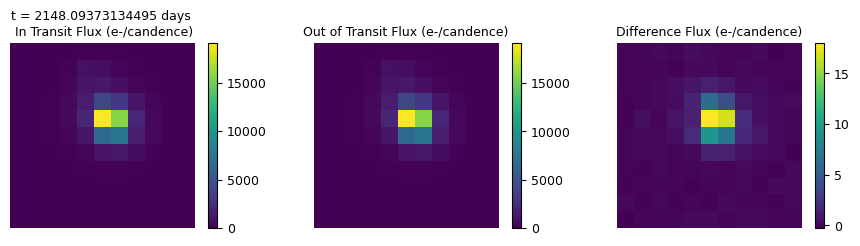

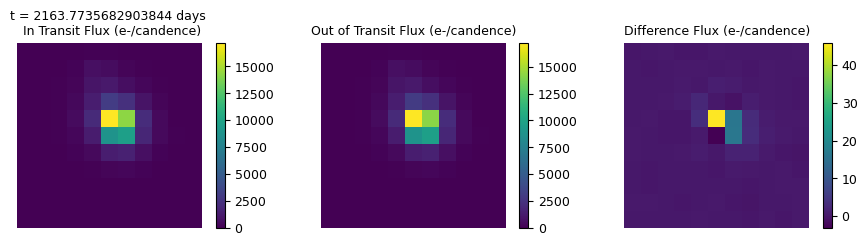

In [15]:
for i in range(np.size(transit_time)):
    plot_in_out_TPF(TOI_ID, Sector, tpf, transit_time[i], duration, i)

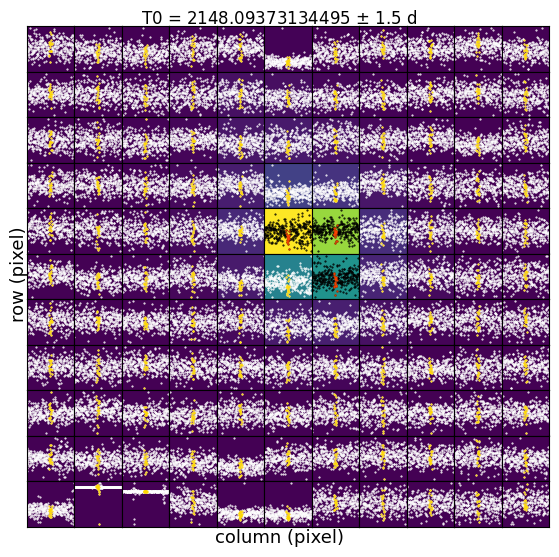

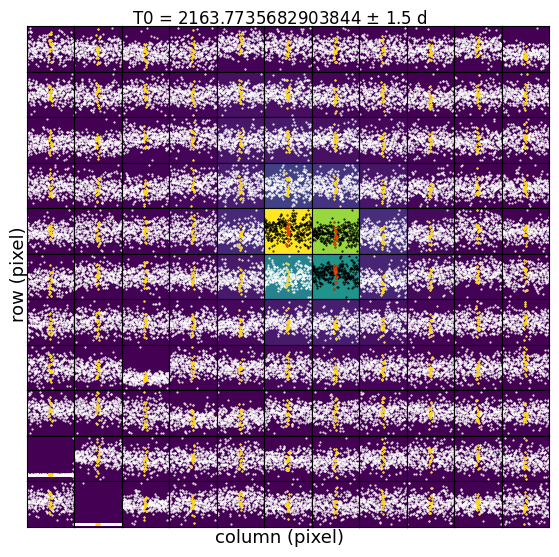

In [16]:
for i in range(np.size(transit_time)):
    plot_pixel_level_LC(TOI_ID, Sector, tpf, transit_time[i], i, duration)

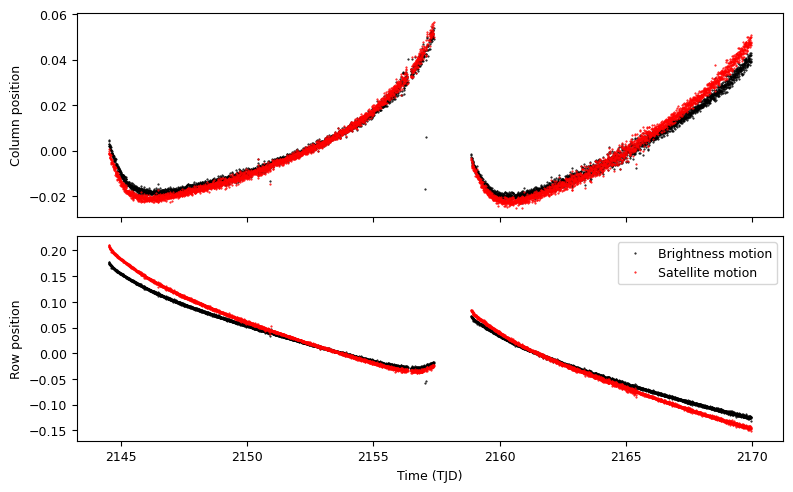

In [17]:
# bin the data
lc_bin = lc.bin(7/60/24)

# set up the plotting region
fig, ax = plt.subplots(2,1, figsize = (8,5), sharex= True)

# plot the two different centroid motions in the column and row positions
ax[0].plot(lc_bin.time.value, lc_bin.mom_centr1.value-np.nanmean(lc_bin.mom_centr1.value), color = 'black', lw = 0, marker = '.', ms = 1)
ax[0].plot(lc_bin.time.value, lc_bin.pos_corr1.value-np.nanmean(lc_bin.pos_corr1.value), color = 'red', lw = 0, marker = '.', ms = 1)

ax[1].plot(lc_bin.time.value, lc_bin.mom_centr2.value - np.nanmedian(lc_bin.mom_centr2.value), color = 'black', lw = 0, marker = '.', ms = 1, label = 'Brightness motion')
ax[1].plot(lc_bin.time.value, lc_bin.pos_corr2.value- np.nanmedian(lc_bin.pos_corr2.value), color = 'red', lw = 0, marker = '.', ms = 1, label = 'Satellite motion')

# define the axis labels
ax[0].set_ylabel("Column position")
ax[1].set_ylabel("Row position")
plt.xlabel("Time (TJD)")
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(os.path.join('', 'TOI_'+TOI_ID+'_S_'+Sector+'_CP_.jpeg'), format='jpeg', dpi=600, bbox_inches = 'tight')      

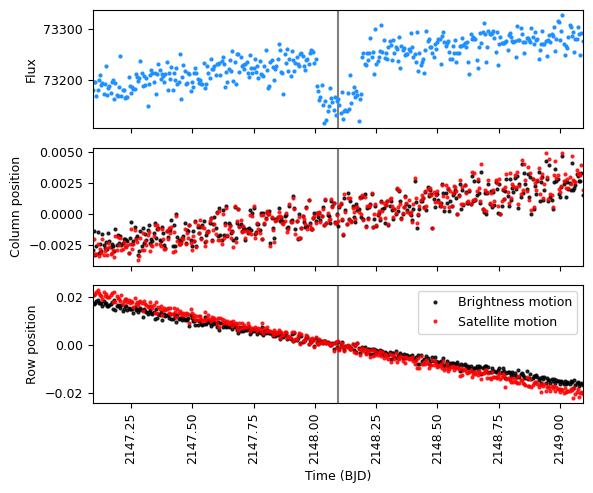

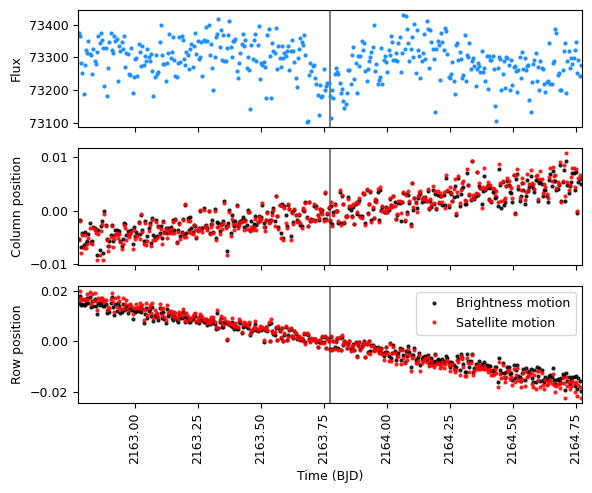

In [18]:
window = 1 # let's look at the one days surrounding the target 

for i in range(np.size(transit_time)):
    plot_centroids(TOI_ID, Sector, lc, transit_time[i], window, i)

Directory (03) Data Modeling) is already available to store output


 Orbital Period (d) :  15.665999999998384 d 
 Epoch Time (BTJD) :  2148.09373134495 
 Transit Duration (d) :  0.2 d


(-0.5, 0.5)

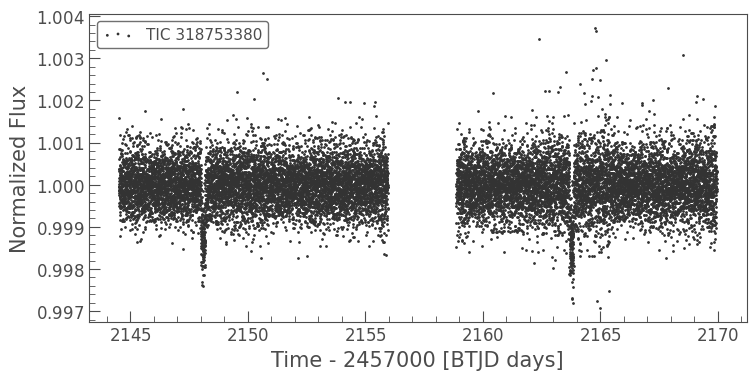

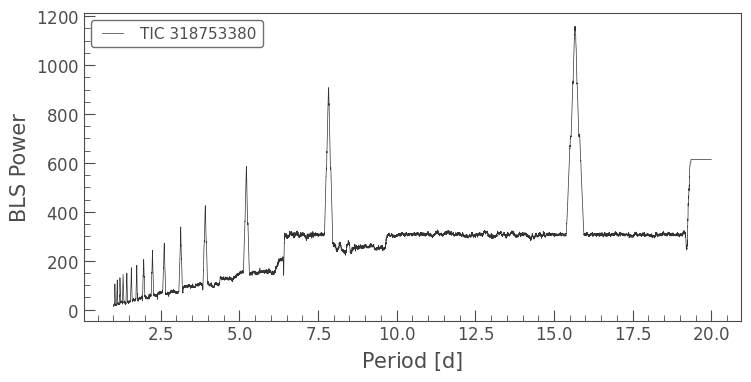

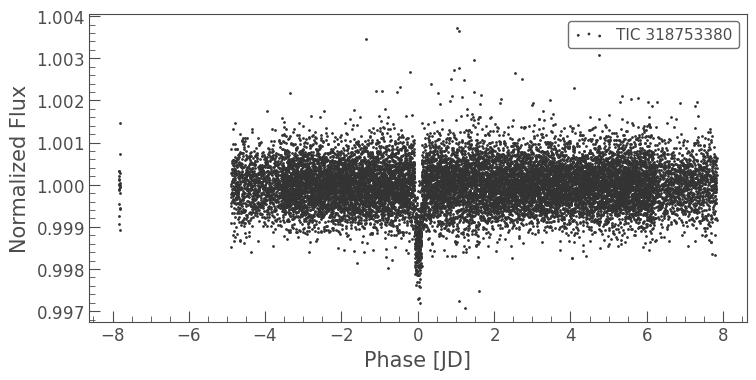

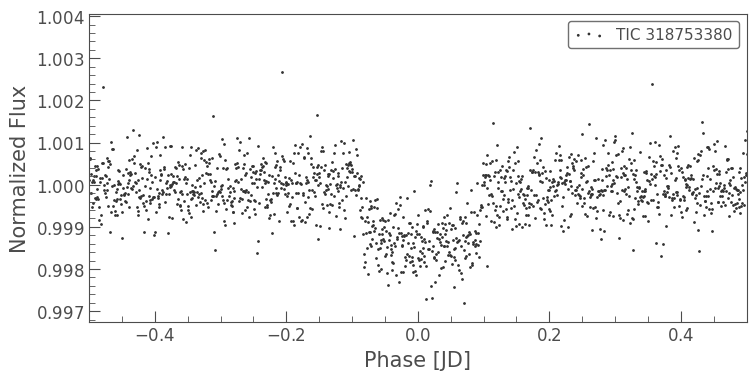

In [25]:
os.chdir('../..')
check_make_dir('03) Data Modeling')
os.chdir('03) Data Modeling')

transit_time = results_tls.T0
duration = duration + 0.05
# Based on previous evaluated values we have to mask all the transits and need to de-trend the remaining portion
# In a view to avoide the stellar activity 

# Mask the transits 
# Paste below the data (period, epoch time, transit duration) calculated above.
masked_lc = lc.create_transit_mask(period = period, 
                                   transit_time = transit_time, 
                                   duration = duration)

# Detrending the out of transit part
flat_lc = lc.flatten(mask = masked_lc)
flat_lc.scatter()

# Create the Periodogram of Detrended Light Curve
pg_flatten = flat_lc.to_periodogram(method = 'bls', period = np.arange(1,20,0.001))
pg_flatten.plot()

# Print the evaluated values
time_period = pg_flatten.period_at_max_power
transit_epoch_time = pg_flatten.transit_time_at_max_power
transit_duration = pg_flatten.duration_at_max_power
print("\n")
print(" Orbital Period (d) : ",time_period,"\n","Epoch Time (BTJD) : ",transit_time,\
      "\n","Transit Duration (d) : ", transit_duration)

# Fold the light curve based on calculated Time Period & Epoch Time
folded_lc = flat_lc.fold(period = period, epoch_time = transit_time)

# Plot whole folded light curve
folded_lc.scatter()

# Focused on transit
folded_lc.scatter()
plt.xlim(-0.5,0.5)

In [26]:
# Add columns pdcsap & pdcsap_err to the .fits file
# These two columns will be used while modeling as a raw data
pdcsap = flat_lc.flux
pdcsap_err = flat_lc.flux_err

# Save the File
processed_lc = flat_lc.to_fits(path = 'LC_'+Sector+'.fits', \
                               overwrite = True, pdcsap_flux = pdcsap, pdcsap_flux_err = pdcsap_err)

# Open the file and print
Final_Light_Curve = lk.read('LC_'+Sector+'.fits')
Final_Light_Curve

time,flux,flux_err,pdcsap_flux,pdcsap_flux_err,centroid_col,centroid_row,mom_centr1,mom_centr2,quality
,,electron / s,,,,,,,
object,float64,float32,float64,float64,float64,float64,float64,float64,int32
2144.5203192294866,0.9999398194033922,0.0004171834443695843,0.9999398194033922,0.0004171834355753009,676.5006237493876,1377.9708751557434,676.5006237493876,1377.9708751557434,0
2144.5217081466317,0.999569435728421,0.00041704910108819604,0.999569435728421,0.00041704908715726763,676.4956714485962,1377.9699645138342,676.4956714485962,1377.9699645138342,0
2144.523097063776,1.001576519970107,0.00041750268428586423,1.001576519970107,0.0004175026804466775,676.4972648229968,1377.9708384589158,676.4972648229968,1377.9708384589158,0
2144.52448598092,0.9998487705005946,0.0004171130422037095,0.9998487705005946,0.0004171130541618203,676.497482513663,1377.9707729443644,676.497482513663,1377.9707729443644,0
2144.5258748976,0.9998786813882472,0.0004171630716882646,0.9998786813882472,0.00041716307390377076,676.4973138991481,1377.969373032966,676.4973138991481,1377.969373032966,0
2144.5272638147453,1.0008565092558297,0.00041730402153916657,1.0008565092558297,0.00041730401789592786,676.495060925128,1377.9712565208367,676.495060925128,1377.9712565208367,0
2144.5286527318895,1.0003232054737088,0.00041725271148607135,1.0003232054737088,0.0004172527258022843,676.4965024158878,1377.9697260340852,676.4965024158878,1377.9697260340852,0
2144.530041648569,1.0003708798313593,0.00041726327617652714,1.0003708798313593,0.0004172632616764281,676.4949622923467,1377.9713053571686,676.4949622923467,1377.9713053571686,0


In [27]:
# Name of Target Star
# Leave one space between TOI and ID i.e., TOI 1148
Target_Star = 'TOI '+TOI_ID

# -------------------------------------------------
# Some User inputs !!
# [value, uncertainty]
# -------------------------------------------------
# -------------------------------------------------
# Normal Distribution: [mean value, deviation]
# Uniform Distribution: [minimum value, maximum value]
# -------------------------------------------------
Period, Period_Deviation = [period, 0.001]         # Normal Distribution
Time, Time_Deviation = [2457000 + transit_time, 0.1]   # Normal Distribution
a_lower, a_upper = [1, 100]                 # Uniform distribution
# -------------------------------------------------

filename = 'LC_'+Sector+'.fits'
output_folder = 'Sector '+Sector    # Folder in which Results will be saved

# ---------------------------------------------------------------------------------------------------------
# Priors for different Parameters 
# ---------------------------------------------------------------------------------------------------------

# r1 & r2 are Parametrization of Espinoza (2018) for Rp/Rs and Impact Parameter
# uniform distribution : Suggested to fit in between [0, 1]

# q1 & q2 are LD Parametrization of Kipping for two parameter LD Laws except logarithmic Law 
# uniform distribution : Suggested to fit in between [0, 1]

# Eccentricity & Argument of Periastron are fixed. ecc = 0 & omega = 90

# ---------------------------------------------------------------------------------------------------------

# Define the master prior dictionary. First define the TRANSIT priors
priors = {}

# Name of the parameters to be fit:
params = ['P_p1', 't0_p1', 'r1_p1', 'r2_p1', 'q1_TESS', 'q2_TESS', 'a_p1', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS', \
          'ecc_p1', 'omega_p1']

# Distribution for each of the parameters:
dists = ['normal', 'normal', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'fixed', 'normal', 'loguniform', \
         'fixed', 'fixed']


hyperps = [[Period, Period_Deviation], [Time, Time_Deviation], [0, 1], [0, 1], [0, 1], [0, 1],\
           [a_lower, a_upper], 1.0, [0,0.1], [0.1, 1000], 0, 90]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [28]:
# First get TESS photometric data
t, f, ferr = juliet.get_TESS_data(filename)

# Put data in dictionaries, add 2457000 to the times to convert from TESS JD to JD:
times, fluxes, fluxes_error = {}, {}, {}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t + 2457000, f, ferr

# RV data is given in a file, so let's just pass the filename to juliet and load the dataset:
dataset = juliet.load(priors = priors, t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = output_folder)

# And now let's fit it!
results = dataset.fit(sampler = 'dynesty', n_live_points = 500, nwalkers = 100000, nsteps = 300000, nburnin = 500000, \
                      emcee_factor = 0.0001, ecclim = 1.0, pl = 0.0, pu = 1.0, ta = 2457000.0, \
                      nthreads = None, dynamic = True, \
                      dynesty_bound = 'multi', dynesty_sample = 'rwalk', dynesty_nthreads = None, \
                      dynesty_n_effective = np.inf, dynesty_use_stop = True, dynesty_use_pool = None)

Detected dynesty sampler output files --- extracting from Sector 31/_dynesty_NS_posteriors.pkl


In [29]:
transit_model = results.lc.evaluate('TESS') # Evaluating the model

# ------------------------------------------------------------------------------------------
# Extract period and time of transit center for the planet
# ------------------------------------------------------------------------------------------
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']),\
        np.median(results.posteriors['posterior_samples']['t0_p1'])

# ------------------------------------------------------------------------------------------
# Define plot, get phases, plot data and best-fit model
# ------------------------------------------------------------------------------------------
phases0 = juliet.get_phases(dataset.times_lc['TESS'], P, t0) 
idx0 = np.argsort(phases0)

# Data binning
p_bin, y_bin, yerr_bin = juliet.bin_data(phases0[idx0], dataset.data_lc['TESS'][idx0], 80) 
p_bin1, y_bin1, yerr_bin1 = juliet.bin_data(phases0[idx0], dataset.data_lc['TESS'][idx0] - transit_model[idx0], 80) 

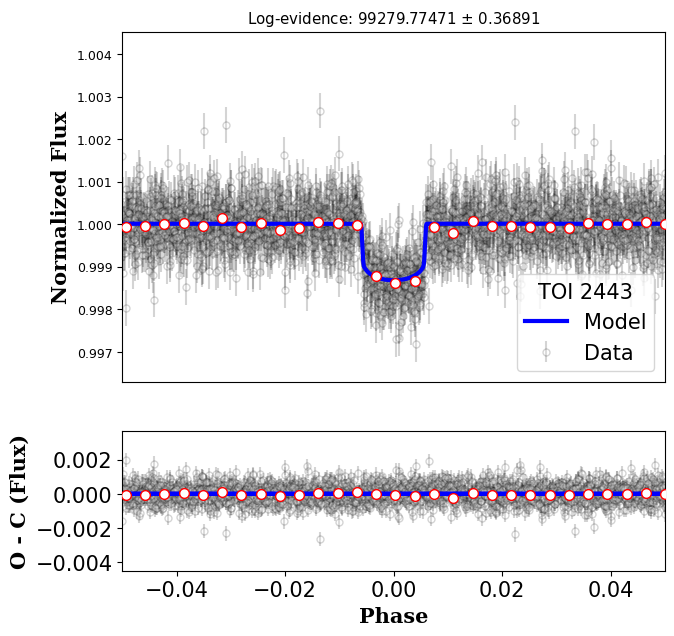

In [30]:
# ------------------------------------------------------------------------------------------
# Plotting the Graph
f, (f1, f2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [5,2]})
f.set_size_inches(7,7)
# ------------------------------------------------------------------------------------------

f1.errorbar(phases0, dataset.data_lc['TESS'], yerr= dataset.errors_lc['TESS'],\
             fmt='ko', mfc = 'white',markersize=5, alpha = 0.17, zorder = 1, label = "Data") # Plot whole data set in background
f1.plot(phases0[idx0],transit_model[idx0], color='b', lw = 3, zorder = 2, label = "Model")   # Plot the model 
f1.errorbar(p_bin, y_bin, yerr = yerr_bin, fmt='ro', mfc = 'white',markersize=7, zorder = 3) # Plot the binned data for reference

f1.set_title('Log-evidence: {0:.5f} $\pm$ {1:.5f}'.format(results.posteriors['lnZ'],results.posteriors['lnZerr']))
f1.set_ylabel('Normalized Flux',fontdict=font1, weight = "bold",fontsize="15")
f1.legend(title = Target_Star, loc = "lower right", fontsize = 15, title_fontsize = 15)

f1.set_xticks([])
plt.yticks(fontsize = 15)

f1.set_xlim([-0.05, 0.05])
#f1.set_ylim([0.980, 1.02])

# ---------------------------------------------------------------------------------------------
# Residual Plot
# ---------------------------------------------------------------------------------------------

f2.errorbar(phases0, transit_model - dataset.data_lc['TESS'], yerr= dataset.errors_lc['TESS'],\
             fmt='ko', mfc = 'white',markersize=5, alpha = 0.17, zorder = 1)

f2.plot(phases0, np.zeros(np.size(phases0)), color='b', lw = 3, zorder = 2)

f2.errorbar(p_bin1, y_bin1, yerr = yerr_bin1, fmt='ro', mfc = 'white',markersize=7, zorder = 3)

f2.set_xlabel('Phase',fontdict=font1, weight = "bold",fontsize="15")
f2.set_ylabel('O - C (Flux)',fontdict=font1, weight = "bold",fontsize="15")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

f2.set_xlim([-0.05, 0.05])
#f2.set_ylim([-0.02, 0.02])

# Save figure to output folder
f.savefig(os.path.join(output_folder, 'TOI_'+Target_Star[4:]+'_Transit.jpeg'), format='jpeg', dpi=600, bbox_inches = 'tight')

In [31]:
# Different Paths to save the processed data
dat_file = output_folder+'/posteriors.dat'
with open(dat_file, 'r') as file:
    text = file.read()
    print(text)
    
PI = np.pi
P = np.median(results.posteriors['posterior_samples']['P_p1'])
T0 = np.median(results.posteriors['posterior_samples']['t0_p1'])
r1 = np.median(results.posteriors['posterior_samples']['r1_p1'])
r2 = np.median(results.posteriors['posterior_samples']['r2_p1'])
pl = results.posteriors['pl']
pu = results.posteriors['pu']
ars = np.median(results.posteriors['posterior_samples']['a_p1'])

Ar = (pu - pl)/(2 + pu + pl)
if r1 > Ar:
    b = (1 + pl)*(1 + (r1 - 1)/(1 - Ar))
    rprs = (1 - r2)*pl + r2*pu
if r1 <= Ar:
    b = (1 + pl) + np.sqrt(r1/Ar)*r2*(pu - pl)
    rprs = pu + (pl - pu)*np.sqrt(r1/Ar)(1 - r2)
    
inc = np.arccos(b/ars)
Td = (P/PI)*np.arcsin(np.sqrt(1 + rprs - b**2)/(np.sqrt(1 - (np.cos(inc))**2)*ars))

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 15.6690553089 	 	 0.0007176590 	 	 0.0007331307
t0_p1              	 	 2459148.0989774023 	 	 0.0008142819 	 	 0.0008436372
r1_p1              	 	 0.5234917896 	 	 0.1340249390 	 	 0.1123390761
r2_p1              	 	 0.0345945093 	 	 0.0006338731 	 	 0.0006425555
p_p1               	 	 0.0345945093 	 	 0.0006338731 	 	 0.0006425555
b_p1               	 	 0.2852376844 	 	 0.2010374085 	 	 0.1685086142
inc_p1             	 	 89.3785197316 	 	 0.3766763075 	 	 0.5375874079
q1_TESS            	 	 0.1380688590 	 	 0.1393339593 	 	 0.0729041024
q2_TESS            	 	 0.4841866288 	 	 0.3115138740 	 	 0.3327809742
a_p1               	 	 26.2689624819 	 	 0.9796132089 	 	 2.2831854715
mflux_TESS         	 	 -0.0000128381 	 	 0.0000040021 	 	 0.0000039684
sigma_w_TESS       	 	 311.9162178567 	 	 4.8356186924 	 	 4.5459912995





 Orbital Period (d) :  15.674999999998384 d 
 Epoch Time (BTJD) :  2148.09373134495 
 Transit Duration (d) :  0.2 d


(-0.5, 0.5)

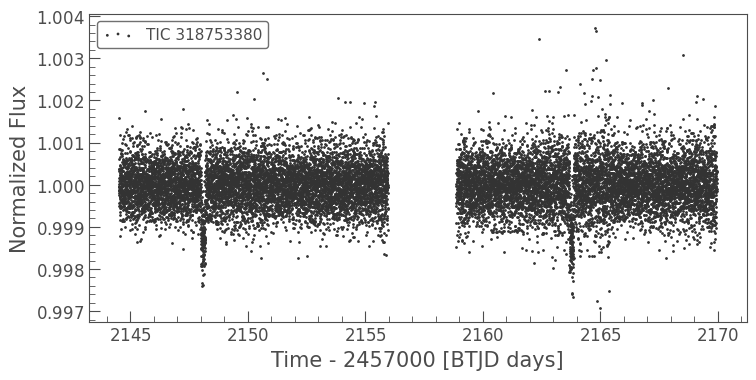

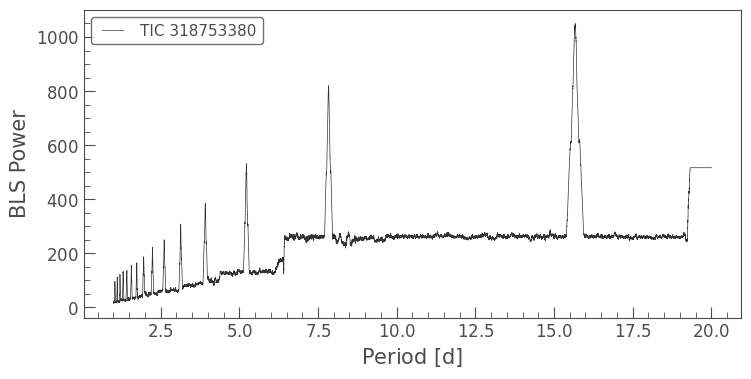

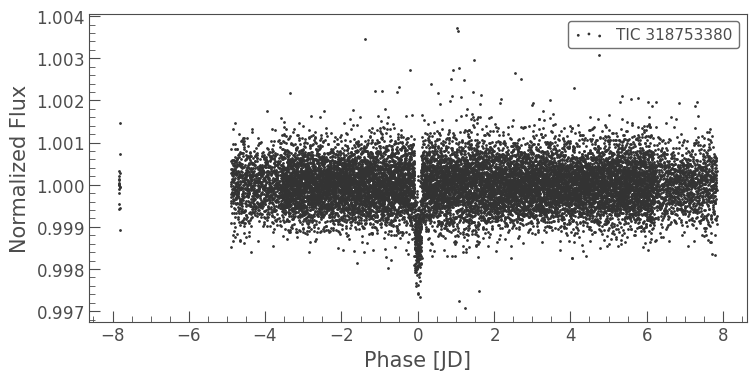

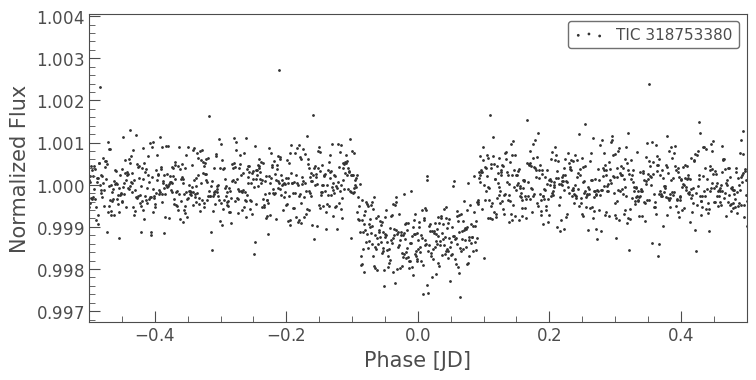

In [32]:
# Based on previous evaluated values we have to mask all the transits and need to de-trend the remaining portion
# In a view to avoide the stellar activity 

# Mask the transits 
# Paste below the data (period, epoch time, transit duration) calculated above.
masked_lc = lc.create_transit_mask(period = P, 
                                   transit_time = T0 - 2457000, 
                                   duration = Td + 0.05)

# Detrending the out of transit part
flat_lc = lc.flatten(mask = masked_lc)
flat_lc.scatter()

# Create the Periodogram of Detrended Light Curve
pg_flatten = flat_lc.to_periodogram(method = 'bls', period = np.arange(1,20,0.001))
pg_flatten.plot()

# Print the evaluated values
time_period = pg_flatten.period_at_max_power
transit_epoch_time = pg_flatten.transit_time_at_max_power
transit_duration = pg_flatten.duration_at_max_power
print("\n")
print(" Orbital Period (d) : ",time_period,"\n","Epoch Time (BTJD) : ",transit_time,\
      "\n","Transit Duration (d) : ", transit_duration)

# Fold the light curve based on calculated Time Period & Epoch Time
folded_lc = flat_lc.fold(period = P, epoch_time = T0 - 2457000)

# Plot whole folded light curve
folded_lc.scatter()

# Focused on transit
folded_lc.scatter()
plt.xlim(-0.5,0.5)

In [34]:
os.chdir('..')
print(os.getcwd())
check_make_dir('04) VESPA')
os.chdir("04) VESPA")

check_make_dir('Sector '+Sector)
os.chdir('Sector '+Sector)
print(os.getcwd())

C:\Users\computer\Exoplanets_Programing\FPP Calculator\VaTEST\TOI 2443
Directory (04) VESPA) is already available to store output
Directory (Sector 31) is already available to store output
C:\Users\computer\Exoplanets_Programing\FPP Calculator\VaTEST\TOI 2443\04) VESPA\Sector 31


In [35]:
dataframe = etta.download_toi(toi = TOI_ID)
RA = dataframe['RA'].values[0]
DEC = dataframe['Dec'].values[0]

f1 = open('fpp.ini', 'w')

f1.write("name = TOI_"+TOI_ID+"\n") 
f1.write("ra = "+format(RA)+"\n") 
f1.write("dec = "+format(DEC)+"\n") 

f1.write(" \n") 

f1.write("period = "+format(P)+"\n") 
f1.write("rprs = "+format(rprs)+"\n") 
f1.write("photfile = transit.txt\n") 

f1.write(" \n") 

f1.write("cadence = 0.0013888888888889\n") 
f1.write("band = 'TESS' \n") 

f1.write(" \n") 

f1.write("[constraints] \n") 
f1.write("maxrad = "+format(effective_radius, '.6f')+"\n") 
f1.write("secthresh = "+format(0.1*rprs**2)) 

f1.close

f1 = open('fpp.ini', 'r')
print(f1.read())
f1.close

Fetching data from https://exofop.ipac.caltech.edu/tess/download_toi.php?output=pipe&toi=2443
name = TOI_2443
ra = 02:40:43.17
dec = 01:11:58.83
 
period = 15.669055308923207
rprs = 0.034594509316568336
photfile = transit.txt
 
cadence = 0.0013888888888889
band = 'TESS' 
 
[constraints] 
maxrad = 64.043017
secthresh = 0.00011967800748541335


<function TextIOWrapper.close()>

In [36]:
phase_range = Td + 0.13
f2 = open('transit.txt', 'w').close()
for num in range(np.size(folded_lc.flux.value)):
    check = np.isnan(folded_lc.flux.value[num])
    if check == False:
        if abs(folded_lc.time.value[num]) < phase_range:
            f2 = open('transit.txt', 'a')
            f2.write(""+str(folded_lc.time.value[num])+" "+str(folded_lc.flux.value[num])+" "+str(folded_lc.flux_err.value[num])+"\n")  

print(open('transit.txt', 'r').read())
f2.close()

-0.3147252143730832 0.9999638130979297 0.0004180439860699802
-0.3144114600502966 0.9988661993665306 0.000417523071357322
-0.3133363139922949 1.0000830451444256 0.00041800852204964834
-0.3130225969124041 0.9984492663420717 0.0004170294765053641
-0.31194741314629937 0.9997425766633286 0.0004180815885861336
-0.31163373424017565 0.9993804256711072 0.00041718521682836596
-0.31055851276505564 0.999773457871093 0.000417982017199451
-0.31024487110183047 1.0004019698429636 0.0004180329941063347
-0.3091696119190601 0.9998363533054039 0.00041798995639650215
-0.3088560079643934 0.9995323494831109 0.00041808248547338975
-0.3077807110721551 0.9998515570237434 0.0004180899313901333
-0.3074671448260509 1.0007196517252808 0.00041821861988759095
-0.30639181069182087 1.0006747843077803 0.0004181117291096758
-0.3060782816881584 0.9998336483544359 0.0004178607933474481
-0.30500290984491585 0.999898237523992 0.0004179878530526746
-0.3046894185507241 0.9999582183443759 0.0004180671621246103
-0.30361400946367

In [40]:
os.chdir('../..')
check_make_dir('05) TRICERATOPS')
os.chdir('05) TRICERATOPS')

Directory (05) TRICERATOPS) is already available to store output


In [44]:
ip_txt_file = pd.read_csv('../04) VESPA/Sector '+Sector+'/transit.txt', delim_whitespace=True)
ip_txt_file.to_csv('TOI_'+TOI_ID+'_'+Sector+'.csv', index = None)

In [68]:
arr = np.transpose(np.where(tpf.pipeline_mask == True))
arr[:,0] += tpf.row
arr[:,1] += tpf.column
arr[:,[0,1]] = arr[:,[1,0]]
pixel_location = open('Pixel_Location_'+Sector+'.txt', 'w')
pixel_location.write(str(arr))
pixel_location.close()